In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
import ROOT
import uproot
import os
import sys
import tqdm
import pandas as pd

%jsroot on
# %matplotlib qt
%matplotlib inline

Welcome to JupyROOT 6.30/00


In [2]:
os.environ['PATH'] = '/Library/TeX/texbin:' + os.environ['PATH']
mpl.rc('font', **{'family':'serif', 'serif':['Computer Modern Roman']})
params = {'backend': 'pdf',
          'axes.labelsize': 20,
          'font.size': 20,
          'legend.fontsize': 20,
          'xtick.labelsize': 20,
          'ytick.labelsize': 20,
          'text.usetex': True,
          'figure.figsize': (5,5),
          'axes.unicode_minus': True}
mpl.rcParams.update(params)

In [3]:
# file_input_name = '../runs/calibration/calibration_-0.85000_-0.85000_-0.85000.root'
# file_input_name = '../runs/calibration/calibration_-0.85000_-0.85000_-0.85000.root'
# file_input_name = '../runs/output_NEST_e-_1MeV.root'
# file_input_name = '../build/event_total.root'
file_input_name = '../build/event.root'
histogram_directory = 'photoSensor_hits_histograms'
file_input_pyroot = ROOT.TFile(file_input_name)
file_input_uproot = uproot.open(file_input_name)

histogram_names = [name for name in file_input_uproot.keys() if "/photoSensor_" in name]
print(histogram_names)

histogram_titles = [file_input_pyroot.Get(name).GetTitle() for name in histogram_names]
print(histogram_titles)

histogram_positions = [(float(title.split('_')[2]), float(title.split('_')[3]), float(title.split('_')[4])) for title in histogram_titles]
print(histogram_positions)

histogram_wall = [title.split('_')[1] for title in histogram_titles]
print(histogram_wall)

tree_names = [name for name in file_input_uproot.keys() if histogram_directory not in name]
print(tree_names)

['photoSensor_hits_histograms/photoSensor_0;1', 'photoSensor_hits_histograms/photoSensor_1;1', 'photoSensor_hits_histograms/photoSensor_2;1', 'photoSensor_hits_histograms/photoSensor_3;1', 'photoSensor_hits_histograms/photoSensor_4;1', 'photoSensor_hits_histograms/photoSensor_5;1', 'photoSensor_hits_histograms/photoSensor_6;1', 'photoSensor_hits_histograms/photoSensor_7;1', 'photoSensor_hits_histograms/photoSensor_8;1', 'photoSensor_hits_histograms/photoSensor_9;1', 'photoSensor_hits_histograms/photoSensor_10;1', 'photoSensor_hits_histograms/photoSensor_11;1', 'photoSensor_hits_histograms/photoSensor_12;1', 'photoSensor_hits_histograms/photoSensor_13;1', 'photoSensor_hits_histograms/photoSensor_14;1', 'photoSensor_hits_histograms/photoSensor_15;1', 'photoSensor_hits_histograms/photoSensor_16;1', 'photoSensor_hits_histograms/photoSensor_17;1', 'photoSensor_hits_histograms/photoSensor_18;1', 'photoSensor_hits_histograms/photoSensor_19;1', 'photoSensor_hits_histograms/photoSensor_20;1', '

In [4]:
tree = file_input_uproot['photoSensor_hits;1']

position_relative_x = tree['photoSensor_hits_position_relative_x'].array()
position_relative_y = tree['photoSensor_hits_position_relative_y'].array()

histogram = file_input_pyroot.Get(histogram_names[0])
n_bins_x = histogram.GetNbinsX()
n_bins_y = histogram.GetNbinsY()
values = np.zeros((n_bins_x, n_bins_y))
x_edges = []
y_edges = []
for i in range(1, n_bins_x + 2):
    x_edges.append(histogram.GetXaxis().GetBinLowEdge(i))
for i in range(1, n_bins_y + 2):
    y_edges.append(histogram.GetYaxis().GetBinLowEdge(i))
x_edges[ 0] -= 1e-9
y_edges[ 0] -= 1e-9
x_edges[-1] += 1e-9
y_edges[-1] += 1e-9

position_relative_x_bins = pd.Series(pd.cut(np.array(position_relative_x), bins=x_edges, retbins=False))
position_relative_y_bins = pd.Series(pd.cut(np.array(position_relative_y), bins=y_edges, retbins=False))
position_relative_x_binned = position_relative_x_bins.apply(lambda x: (x.right + x.left) / 2)
position_relative_y_binned = position_relative_y_bins.apply(lambda x: (x.right + x.left) / 2)

time = tree['photoSensor_hits_time'].array()
photoSensorID = tree['photoSensor_hits_photoSensorID'].array()
photoSensorPosition = [(float(ID.split('_')[2]), float(ID.split('_')[3]), float(ID.split('_')[4])) for ID in photoSensorID]
photoSensorWall = [ID.split('_')[1] for ID in photoSensorID]
photoSensorDirection = []
for wall in photoSensorWall:
    if wall == '+x':
        photoSensorDirection.append((-1, 0, 0))
    elif wall == '-x':
        photoSensorDirection.append((1, 0, 0))
    elif wall == '+y':
        photoSensorDirection.append((0, -1, 0))
    elif wall == '-y':
        photoSensorDirection.append((0, 1, 0))
    elif wall == '+z':
        photoSensorDirection.append((0, 0, -1))
    elif wall == '-z':
        photoSensorDirection.append((0, 0, 1))

df_hits = pd.DataFrame(columns=['sensor_name', 'sensor_direction', 'sensor_position', 'relativePosition', 'relativePosition_binned', 'time'])
df_hits['sensor_name'] = photoSensorID
df_hits['sensor_direction'] = photoSensorDirection
df_hits['sensor_position'] = photoSensorPosition
df_hits['relativePosition'] = list(zip(position_relative_x, position_relative_y))
df_hits['relativePosition_binned'] = list(zip(position_relative_x_binned, position_relative_y_binned))
df_hits['time'] = time

print(df_hits)


                                             sensor_name sensor_direction  \
0      /DSPD_+x_1114.704220_770.000000_-990.000000_1_...       (-1, 0, 0)   
1      /DSPD_+x_1114.704220_550.000000_-990.000000_2_...       (-1, 0, 0)   
2      /DSPD_+x_1114.704220_-990.000000_-990.000000_9...       (-1, 0, 0)   
3      /DSPD_+x_1114.704220_550.000000_-770.000000_12...       (-1, 0, 0)   
4      /DSPD_+x_1114.704220_-110.000000_-770.000000_1...       (-1, 0, 0)   
...                                                  ...              ...   
23804  /DSPD_-z_770.000000_330.000000_-1114.704220_86...        (0, 0, 1)   
23805  /DSPD_-z_990.000000_-550.000000_-1114.704220_9...        (0, 0, 1)   
23806  /DSPD_-z_990.000000_330.000000_-1114.704220_96...        (0, 0, 1)   
23807  /DSPD_-z_990.000000_550.000000_-1114.704220_97...        (0, 0, 1)   
23808  /DSPD_-z_990.000000_550.000000_-1114.704220_97...        (0, 0, 1)   

                    sensor_position  \
0       (1114.70422, 770.0, -990.0) 

In [5]:
CM_PER_RAD = 34.14230382
MM_PER_CM = 10
CM_PER_M = 100
Y_LIM = 10 * MM_PER_CM
C_M = 299792458
C_CM = C_M * CM_PER_M
N_XENON = 1.84
C_XENON_M_PER_S = C_M / N_XENON
C_XENON_CM_PER_S = C_XENON_M_PER_S * CM_PER_M
C_XENON_MM_PER_S = C_XENON_CM_PER_S * MM_PER_CM
NS_PER_S = 1e9
C_XENON_MM_PER_NS = C_XENON_MM_PER_S / NS_PER_S

In [6]:
def rToTheta(r):
    return r/(CM_PER_RAD*MM_PER_CM)

In [7]:
# Create empty lists to store r and theta values
r_list = []
theta_list = []
phi_list = []

# Iterate over the rows of df_hits DataFrame
for index, row in df_hits.iterrows():
    # Extract the x and y coordinates from the 'Position' column
    x, y = row['relativePosition_binned']
    
    # Calculate r and theta
    r = np.sqrt(x**2 + y**2)
    if r > Y_LIM:
        df_hits.drop(index, inplace=True)
        continue

    theta = rToTheta(r)
    phi = np.arctan(y / x)
    
    # Append r and theta to the respective lists
    r_list.append(r)
    theta_list.append(theta)
    phi_list.append(phi)

# Append r and theta as new columns to the df_hits DataFrame
df_hits['r'] = r_list
df_hits['theta'] = theta_list
df_hits['phi'] = phi_list

# Print the updated DataFrame
print(df_hits['r'],'\n')
print(df_hits['theta'],'\n')
print(df_hits['phi'])

0        37.121422
1        18.601075
2        77.781746
4        28.178006
5        63.387696
           ...    
23803    83.006024
23804    92.227978
23806    79.309520
23807    48.600412
23808    24.207437
Name: r, Length: 19299, dtype: float64 

0        0.108726
1        0.054481
2        0.227816
4        0.082531
5        0.185657
           ...   
23803    0.243118
23804    0.270128
23806    0.232291
23807    0.142347
23808    0.070902
Name: theta, Length: 19299, dtype: float64 

0        1.095101
1        0.938047
2       -0.785398
4        1.091277
5       -1.460139
           ...   
23803    0.544552
23804    0.163366
23806   -1.328876
23807    0.639386
23808   -0.902507
Name: phi, Length: 19299, dtype: float64


In [8]:
def get_rotationMatrix(vector, target_direction):
    # Normalize vectors
    vector = vector / np.linalg.norm(vector)
    target_direction = target_direction / np.linalg.norm(target_direction)

    # Find the axis of rotation using the cross product
    axis_of_rotation = np.cross(vector, target_direction)

    # Calculate the angle of rotation using the dot product
    angle = np.arccos(np.dot(vector, target_direction))

    # Create a rotation matrix using the axis and angle
    rotation_matrix = np.array([[np.cos(angle) + axis_of_rotation[0]**2 * (1 - np.cos(angle)),
                                 axis_of_rotation[0] * axis_of_rotation[1] * (1 - np.cos(angle)) - axis_of_rotation[2] * np.sin(angle),
                                 axis_of_rotation[0] * axis_of_rotation[2] * (1 - np.cos(angle)) + axis_of_rotation[1] * np.sin(angle)],
                                [axis_of_rotation[1] * axis_of_rotation[0] * (1 - np.cos(angle)) + axis_of_rotation[2] * np.sin(angle),
                                 np.cos(angle) + axis_of_rotation[1]**2 * (1 - np.cos(angle)),
                                 axis_of_rotation[1] * axis_of_rotation[2] * (1 - np.cos(angle)) - axis_of_rotation[0] * np.sin(angle)],
                                [axis_of_rotation[2] * axis_of_rotation[0] * (1 - np.cos(angle)) - axis_of_rotation[1] * np.sin(angle),
                                 axis_of_rotation[2] * axis_of_rotation[1] * (1 - np.cos(angle)) + axis_of_rotation[0] * np.sin(angle),
                                 np.cos(angle) + axis_of_rotation[2]**2 * (1 - np.cos(angle))]])
    return rotation_matrix

In [9]:
# Create empty lists to store output vectors
output_vectors = []

# Iterate over the rows of df_hits DataFrame
for index, row in df_hits.iterrows():
    # Extract the theta, phi, and sensor direction from the respective columns
    theta = row['theta']
    phi = row['phi']
    sensor_direction = row['sensor_direction']
    
    # Calculate the output vector using theta, phi, and sensor direction
    output_vector = [np.sin(theta) * np.cos(phi), np.sin(theta) * np.sin(phi), np.cos(theta)]
    
    # Rotate the output vector
    rotationMatrix = get_rotationMatrix([0, 0, 1], sensor_direction)
    rotated_vector = np.dot(rotationMatrix, output_vector)
    
    # Append the rotated output vector to the list
    output_vectors.append(rotated_vector)

# Add the output vector as a new column to the df_hits DataFrame
df_hits['reconstructedVector_direction'] = output_vectors

# Print the updated DataFrame
print(df_hits['reconstructedVector_direction'])

0        [-0.9940951929753639, 0.09646396942457165, 0.0...
1        [-0.9985162763026462, 0.04391203571523334, 0.0...
2        [-0.9741618992857032, -0.15970064805765724, 0....
4        [-0.9965962446611752, 0.07313984745197528, 0.0...
5        [-0.9828151213061396, -0.18346360787173885, 0....
                               ...                        
23803    [0.20591065046355278, 0.12470645028074322, 0.9...
23804    [0.2633018887851705, 0.04340141023931382, 0.96...
23806    [0.05515031998570908, -0.22350392836313682, 0....
23807    [0.11384242538577795, 0.08465205990224514, 0.9...
23808    [0.043896966204258654, -0.055602823858727626, ...
Name: reconstructedVector_direction, Length: 19299, dtype: object


In [10]:
df_hits['reconstructedVector_time'] = df_hits['reconstructedVector_direction'] * df_hits['time'] * C_XENON_MM_PER_NS

print(df_hits['reconstructedVector_time'])

0        [-270368.9480732086, 26235.77915332898, 13515....
1        [-6489.413327702574, 285.3867849527327, 209.28...
2        [-11192.554084095582, -1834.8676354116112, 183...
4        [-72302.8491048972, 5306.280634915765, 2759.26...
5        [-9872.389850247611, -1842.8941730522881, 204....
                               ...                        
23803    [9355.783031591553, 5666.178455752629, 44099.9...
23804    [3304.2899023936975, 544.6631707242359, 12094....
23806    [388.0427255606759, -1572.5942035880023, 6847....
23807    [1040.8260684914162, 773.9475893910532, 9050.2...
23808    [369.63862554331536, -468.20892568819943, 8399...
Name: reconstructedVector_time, Length: 19299, dtype: object


In [11]:
df_hits['reconstructedPoint_time'] = df_hits['sensor_position'] + df_hits['reconstructedVector_time']

print(df_hits['reconstructedPoint_time'])

0        [-269254.2438532086, 27005.77915332898, 12525....
1        [-5374.709107702574, 835.3867849527327, -780.7...
2        [-10077.849864095582, -2824.8676354116114, 844...
4        [-71188.1448848972, 5196.280634915765, 1989.26...
5        [-8757.685630247612, -2172.8941730522884, -565...
                               ...                        
23803    [10125.783031591553, 5996.178455752629, 42985....
23804    [4074.2899023936975, 874.6631707242359, 10979....
23806    [1378.042725560676, -1242.5942035880023, 5732....
23807    [2030.8260684914162, 1323.947589391053, 7935.5...
23808    [1359.6386255433154, 81.79107431180057, 7284.7...
Name: reconstructedPoint_time, Length: 19299, dtype: object


/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_46410/2650835729.py:19: UserWarning: Matplotlib is currently using pdf, which is a non-GUI backend, so cannot show the figure.
  fig.show()


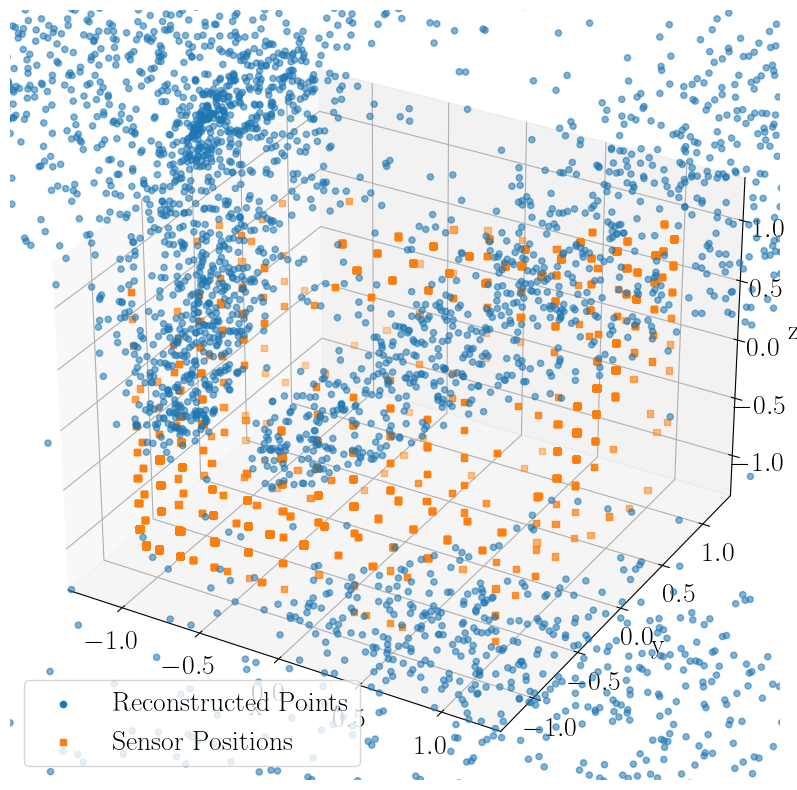

In [12]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_hits['reconstructedPoint_time'].apply(lambda x: x[0])/1000, 
           df_hits['reconstructedPoint_time'].apply(lambda x: x[1])/1000, 
           df_hits['reconstructedPoint_time'].apply(lambda x: x[2])/1000,
           label='Reconstructed Points')
ax.scatter(df_hits['sensor_position'].apply(lambda x: x[0])/1000, 
           df_hits['sensor_position'].apply(lambda x: x[1])/1000, 
           df_hits['sensor_position'].apply(lambda x: x[2])/1000,
           label='Sensor Positions',
           marker='s')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim(-1.3, 1.3)
ax.set_ylim(-1.3, 1.3)
ax.set_zlim(-1.3, 1.3)
ax.legend()
fig.show()


In [13]:
primary_tree = file_input_uproot['primary;1']
position_x = primary_tree['primary_position_x'].array()
position_y = primary_tree['primary_position_y'].array()
position_z = primary_tree['primary_position_z'].array()
time = primary_tree['primary_time'].array()

df_primary = pd.DataFrame(columns=['position', 'time'])
df_primary['position'] = list(zip(position_x, position_y, position_z))
df_primary['time'] = time

/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_46410/3725828540.py:19: UserWarning: Matplotlib is currently using pdf, which is a non-GUI backend, so cannot show the figure.
  fig.show()


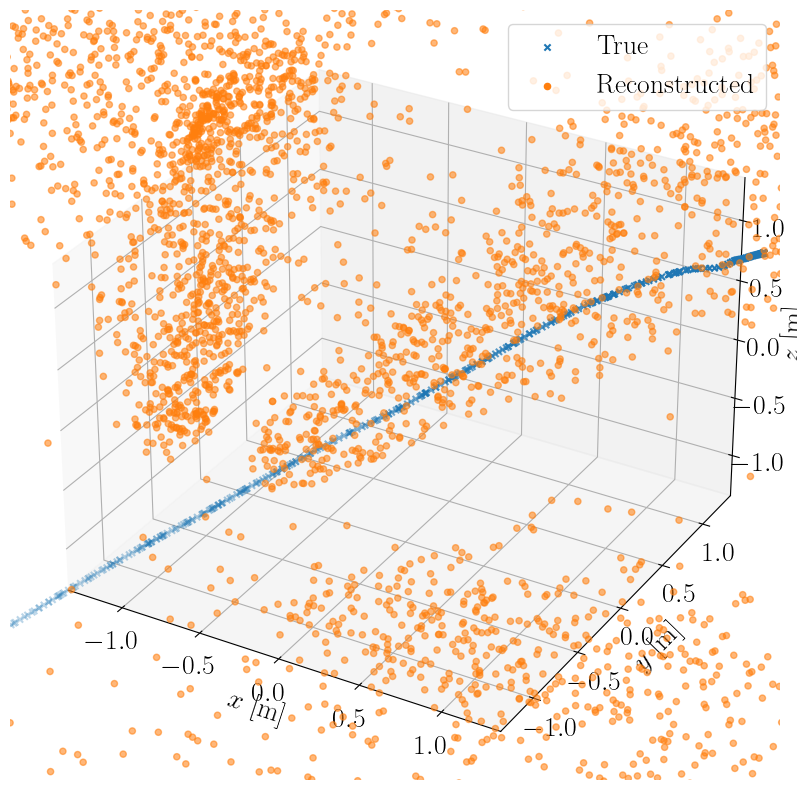

In [14]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_primary['position'].apply(lambda x: x[0])/1000, 
           df_primary['position'].apply(lambda x: x[1])/1000, 
           df_primary['position'].apply(lambda x: x[2])/1000,
           label='True',
           marker='x')
ax.scatter(df_hits['reconstructedPoint_time'].apply(lambda x: x[0])/1000, 
           df_hits['reconstructedPoint_time'].apply(lambda x: x[1])/1000, 
           df_hits['reconstructedPoint_time'].apply(lambda x: x[2])/1000,
           label='Reconstructed')
ax.set_xlabel('$x$ [m]')
ax.set_ylabel('$y$ [m]')
ax.set_zlabel('$z$ [m]')
ax.set_xlim(-1.3, 1.3)
ax.set_ylim(-1.3, 1.3)
ax.set_zlim(-1.3, 1.3)
ax.legend(loc='upper right')
fig.show()

In [15]:
closestPoints = []
minDistances = []
for i, row in tqdm.tqdm(df_hits.iterrows(), total=df_hits.shape[0]):
    recoVectorDirection = row['reconstructedVector_direction']
    sensorPosition = row['sensor_position']

    closestPoint = None
    minDistance = float('inf')
    for i, row in df_primary.iterrows():
        position = np.array(row['position'])
        
        vector = position - sensorPosition
        dot_product = np.dot(vector, recoVectorDirection)
        projection = dot_product / np.linalg.norm(recoVectorDirection)
        closest_point_on_line = sensorPosition + projection * recoVectorDirection
        distance = np.linalg.norm(closest_point_on_line - position)

        if distance < minDistance:
            minDistance = distance
            closestPoint = closest_point_on_line
    
    closestPoints.append(closestPoint)
    minDistances.append(minDistance)

df_hits['reconstructedPoint_distance'] = closestPoints
df_hits['reconstructedPoint_distance_r'] = minDistances

100%|██████████| 19299/19299 [02:18<00:00, 139.63it/s]


In [16]:
furthestPoints = df_hits.nlargest(5, 'reconstructedPoint_distance_r').index
print(df_hits.loc[furthestPoints]['reconstructedPoint_distance_r'])

17417    1692.333389
17418    1572.665544
0        1377.077977
19327    1238.327305
23550    1233.985683
Name: reconstructedPoint_distance_r, dtype: float64


/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_46410/1379057308.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


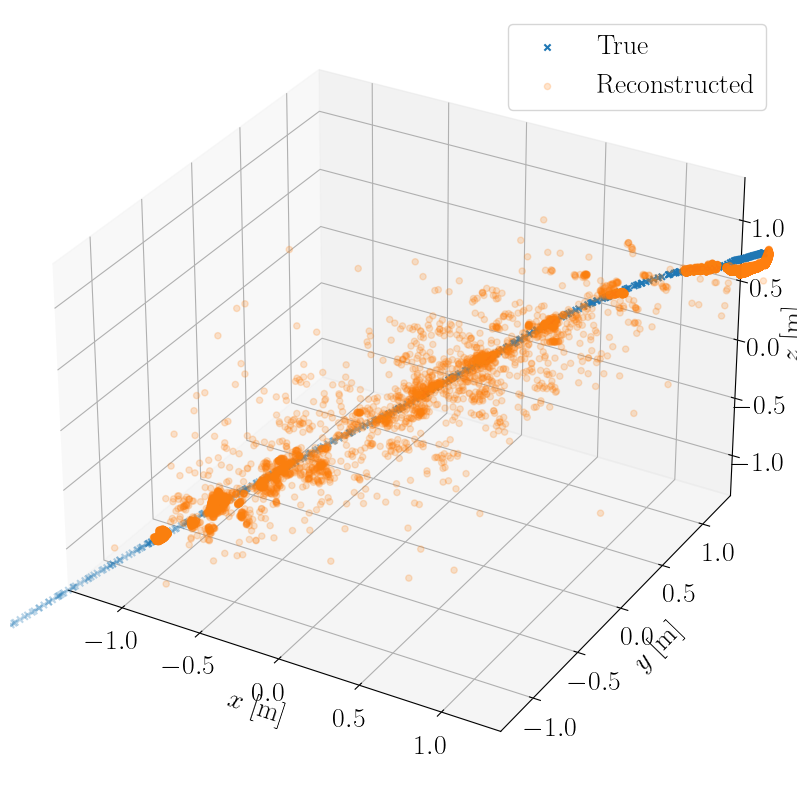

In [17]:
# %matplotlib qt
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_primary['position'].apply(lambda x: x[0])/1000, 
           df_primary['position'].apply(lambda x: x[1])/1000, 
           df_primary['position'].apply(lambda x: x[2])/1000,
           label='True',
           marker='x')
ax.scatter(df_hits['reconstructedPoint_distance'].apply(lambda x: x[0])/1000,
           df_hits['reconstructedPoint_distance'].apply(lambda x: x[1])/1000,
           df_hits['reconstructedPoint_distance'].apply(lambda x: x[2])/1000,
           label='Reconstructed',
           alpha=0.2)
ax.set_xlabel('$x$ [m]')
ax.set_ylabel('$y$ [m]')
ax.set_zlabel('$z$ [m]')
ax.set_xlim(-1.3, 1.3)
ax.set_ylim(-1.3, 1.3)
ax.set_zlim(-1.3, 1.3)
ax.legend(loc='upper right')
fig.show()

sigma = 138.9208407691229


/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_46410/69011451.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Figure size 500x500 with 0 Axes>

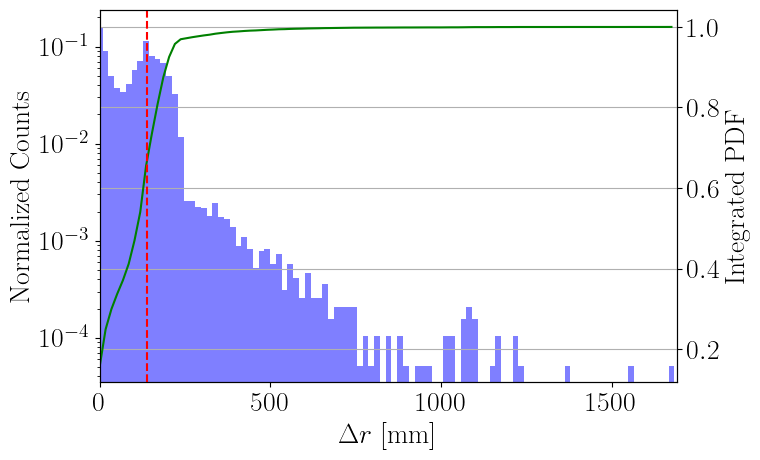

In [18]:
hist, bins, _ = plt.hist(df_hits['reconstructedPoint_distance_r'], bins=100, alpha=0.5, label='Histogram')
cumulative_sum = np.cumsum(hist)
scaled_hist = hist / cumulative_sum[-1]
plt.clf()

fig, ax1 = plt.subplots(figsize=(8, 5))
ax1.bar(bins[:-1], scaled_hist, width=np.diff(bins), alpha=0.5, color='blue')
ax1.set_xlabel(r'$\Delta r$ [mm]')
ax1.set_ylabel('Normalized Counts')
ax1.set_yscale('log')
ax1.set_xlim(0, bins[-1])

ax2 = ax1.twinx()
ax2.plot(bins[:-1], cumulative_sum/cumulative_sum[-1], color='green', label='Histogram')
ax2.set_ylabel('Integrated PDF')

# Add vertical line at 1 sigma
sigma = np.sqrt(cumulative_sum[-1])
print('sigma = {}'.format(sigma))
ax2.axvline(sigma, color='red', linestyle='--', label='1 Sigma')
ax2.grid()

fig.tight_layout()
fig.show()